## This notebook uses the Kiva data set which is part of the [Data Science for Good: Kiva Crowdfunding](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding) Kaggle competition.
### Authors: Aoife Duna (https://github.com/aoifeduna) and Alec Schneider (https://github.com/Alec-Schneider)
### General Assembly Data Science 1-21-2020

### Using three different models, we attempt to predict:
1. Whether or not the loan was fully funded
2. If the loan was fully funded, how quickly it was funded
    - We will use this model for all loans that are predicted to be fully funded
3. If the loan was fully funded, what percentage of the loan was funded
    - This model will be used for all data points that are not predicted to be fully funded. This is beacuse Kiva can still disburse loans that have not been fully funded by crowdfunding

### Columns in the Kiva Loan dataset
- id: Unique ID for loan
- funded_amount: The amount disbursed by Kiva to the field agent(USD)
- loan_amount: The amount disbursed by the field agent to the borrower(USD)
- activity: More granular category
- sector: High level category
- use: Exact usage of loan amount
- country_code: ISO country code of country in which loan was disbursed
- country: Full country name of country in which loan was disbursed
- region: Full region name within the country
- currency: The currency in which the loan was disbursed
- partner_id: ID of partner organization
- posted_time: The time at which the loan is posted on Kiva by the field agent
- disbursed_time: The time at which the loan is disbursed by the field agent to the borrower
- funded_time: The time at which the loan posted to Kiva gets funded by lenders completely
- term_in_months: The duration for which the loan was disbursed in months
- lender_count: The total number of lenders that contributed to this loan
- tags: Hashtags added to the funding request
- borrower_genders: Comma separated M,F letters, where each instance represents a single male/female in the group
- repayment_interval: Interval at which the loan is expected to be repayed
- date

## 1. Exploratory Data Analysis
#### In this section we change columns to the appropriate data type and engineer new features to create important features out of the original columns

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [90]:
kiva = pd.read_csv('../kiva_loans.csv')

In [3]:
kiva.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [3]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-nul

Get the correlations of null values to see how often they appear in the same row

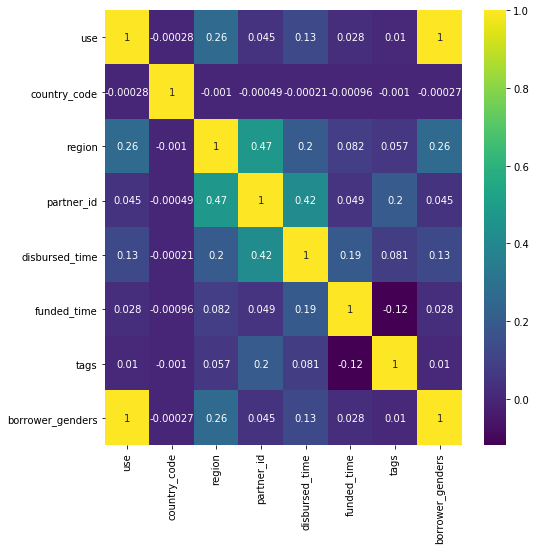

In [13]:
nullval_corrs = kiva.loc[:, kiva.isnull().sum() > 0].isnull().astype(int).corr()
plt.figure(figsize=(8, 8))
sns.heatmap(nullval_corrs, cmap='viridis', annot=True)

In [14]:
nullval_corrs

,use,country_code,region,partner_id,disbursed_time,funded_time,tags,borrower_genders
use,1.000000,-0.000275,0.261644,0.045418,0.127783,0.027907,0.010109,0.998691
country_code,-0.000275,1.000000,-0.001050,-0.000495,-0.000207,-0.000962,-0.001032,-0.000275
region,0.261644,-0.001050,1.000000,0.471324,0.196855,0.082067,0.057401,0.261639
partner_id,0.045418,-0.000495,0.471324,1.000000,0.417663,0.048531,0.198181,0.044835
disbursed_time,0.127783,-0.000207,0.196855,0.417663,1.000000,0.191582,0.080606,0.126381
funded_time,0.027907,-0.000962,0.082067,0.048531,0.191582,1.000000,-0.119731,0.027564
tags,0.010109,-0.001032,0.057401,0.198181,0.080606,-0.119731,1.000000,0.009984
borrower_genders,0.998691,-0.000275,0.261639,0.044835,0.126381,0.027564,0.009984,1.000000


let's get the # of unique values in each col and plot the count in each column

In [80]:
uniques = pd.Series({col: loans[col].unique().shape[0] for col in loans.columns})
uniques = uniques.sort_values(ascending=False)

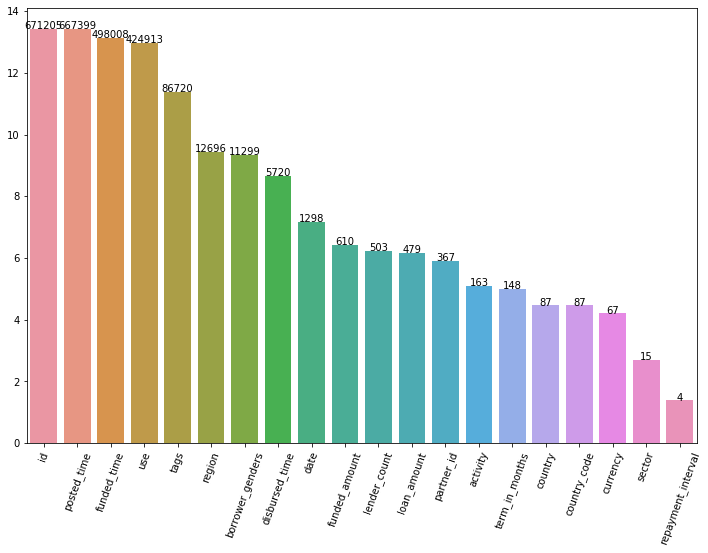

In [82]:
plt.figure(figsize=(12, 8))
uns = sns.barplot(x=uniques.index, y=np.log(uniques.values))
for index, val in enumerate(uniques.values):
    uns.text(index,np.log(val),val, color='black', ha="center")    
uns.tick_params(axis='x', rotation=70, left=True)

plt.savefig('unique_vals_per_col.png')

Change timestamps that are object types, to datetime variables

In [93]:
kiva['funded_time'] = pd.to_datetime(kiva['funded_time'])
kiva['posted_time'] = pd.to_datetime(kiva['posted_time'])

Let's create one of our target variables, TimetoFundMinutes, so we can model how fast a loan gets funded

In [95]:
kiva['TimetoFund'] = kiva['funded_time'] - kiva['posted_time']

In [ ]:
kiva['TimetoFundMinutes'] = kiva['TimetoFund'] / np.timedelta64(1, 'm')

In [ ]:
kiva['TimetoFundMinutes'].fillna(kiva.TimetoFundMinutes.mean(), inplace=True)

Creating target variable LoanFunded to see if the loan reached its full loan_amount

In [110]:
kiva['LoanFunded'] = (kiva.funded_amount.values > 0).astype(np.uint8)

In [111]:
kiva['LoanFunded'].fillna(0, inplace=True)

In [ ]:
kiva['PartnerPresent'] = (kiva.partner_id.values > 0).astype(np.uint8)

In [107]:
kiva['PostedTimeofDay'] = kiva['posted_time'].dt.hour

In [106]:
kiva['PostedDayofWeek'] = kiva.posted_time.dt.day_name()

In [99]:
# The mode value is a single female; filling these nulls with the mode
kiva['borrower_genders'].fillna("female", inplace=True)

In [100]:
kiva['NumberofBorrowers'] = kiva['borrower_genders'].str.split().str.len()

In [101]:
kiva['NumberofFemaleBorrowers'] = kiva.borrower_genders.str.count("female")

In [102]:
kiva['PercentFemaleBorrowers'] = kiva['NumberofFemaleBorrowers'] / kiva['NumberofBorrowers']

Getting the word count in use as we believe that the length of the description may help the loan get funded. If there is no description, we fill in the data with a word count of 0

In [105]:
kiva['CountWordsinDesc'] = kiva['use'].str.split().str.len()

In [109]:
kiva['CountWordsinDesc'].fillna(0, inplace=True)

The amount of tags used on a loan may help a loan get funded as well because lenders may be searching by keyword. The more tags you use, there's a higher chance your loan will come up in a search

In [103]:
kiva['NumberofTags'] = kiva['tags'].str.split().str.len()

In [104]:
kiva['NumberofTags'].fillna(0, inplace=True)

Our last target variable, PercentFunded, will be used to model how much a loan gets funded if it is not fully funded

In [97]:
kiva['PercentFunded'] = kiva['funded_amount'] / kiva['loan_amount']

Dropping all of the variables that we decided would cause multicollinearity in our models, were not relevant to the loan data, and the target variables

In [118]:
# Creating data sets for us to easily call later
X_matrix = kiva.drop(['use','country_code','region', 'currency', 'date', 'TimetoFund', 'tags', 
               'posted_time', 'disbursed_time', 'funded_time', 'NumberofFemaleBorrowers',
               'borrower_genders', 'partner_id', 'TimetoFundMinutes', 'id', 'PercentFunded', 'LoanFunded'], axis=1)
# Dropped these because they are either not additive to the data set or are represented elsewhere

In [120]:
X_matrix.head()

,funded_amount,loan_amount,activity,sector,country,term_in_months,lender_count,repayment_interval,NumberofBorrowers,PercentFemaleBorrowers,NumberofTags,CountWordsinDesc,PostedDayofWeek,PostedTimeofDay,PartnerPresent
0,300.0,300.0,Fruits & Vegetables,Food,Pakistan,12.0,12,irregular,1,1.0,0.0,7.0,Wednesday,6,1
1,575.0,575.0,Rickshaw,Transportation,Pakistan,11.0,14,irregular,2,1.0,0.0,11.0,Wednesday,6,1
2,150.0,150.0,Transportation,Transportation,India,43.0,6,bullet,1,1.0,2.0,17.0,Wednesday,9,1
3,200.0,200.0,Embroidery,Arts,Pakistan,11.0,8,irregular,1,1.0,0.0,12.0,Wednesday,8,1
4,400.0,400.0,Milk Sales,Food,Pakistan,14.0,16,monthly,1,1.0,0.0,4.0,Wednesday,11,1


In [122]:
X_matrix.columns

Index(['funded_amount', 'loan_amount', 'activity', 'sector', 'country',
       'term_in_months', 'lender_count', 'repayment_interval',
       'NumberofBorrowers', 'PercentFemaleBorrowers', 'NumberofTags',
       'CountWordsinDesc', 'PostedDayofWeek', 'PostedTimeofDay',
       'PartnerPresent'],
      dtype='object')

In [ ]:
X_matrix.to_csv('../X_matrix2.csv', index=False)

Creating a DataFrame of all the target variables for later use

In [119]:
y_matrix = kiva[['LoanFunded', 'PercentFunded', 'TimetoFundMinutes']]

In [ ]:
y_matrix.to_csv('../y_matrix2.csv', index=False)

## 2. Training LoanFunded Classifier
#### In this section we are attemtpting to build a classification model that predcits whether or not a Kiva loan will be fully funded.
- Our preprocessing method was to use a [One Hot Encoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html) to transform categorical features such as sector, country and activity into columns that describe the presence of the underlying labels within the categories.
- In order to create and tune our models, we used a variety of methods, including:
    - Cross Validation:
        - [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
        - [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - Models:
        - [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
        - [XGBoostClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

In [129]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [130]:
X = pd.read_csv('../X_matrix2.csv')

In [4]:
y = pd.read_csv('../y_matrix2.csv')
y = y['loan_funded']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
ohe = OneHotEncoder()

In [ ]:
rf1 = RandomForestClassifier(n_jobs=-1)

In [ ]:
rf_pipe = Pipeline([('ohe', ohe), ('rf', rf1)])

In [16]:
rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_f

In [17]:
rf_pipe.score(X_test, y_test)

0.9615816291057896

We got a great R2 score of 96.15%, lets plot the importance of the features

In [23]:
feat_imp1 = pd.Series(rf_pipe.steps[1][1].feature_importances_, index=feats1).sort_values(ascending=False)

Text(0.5, 0, 'Feature')

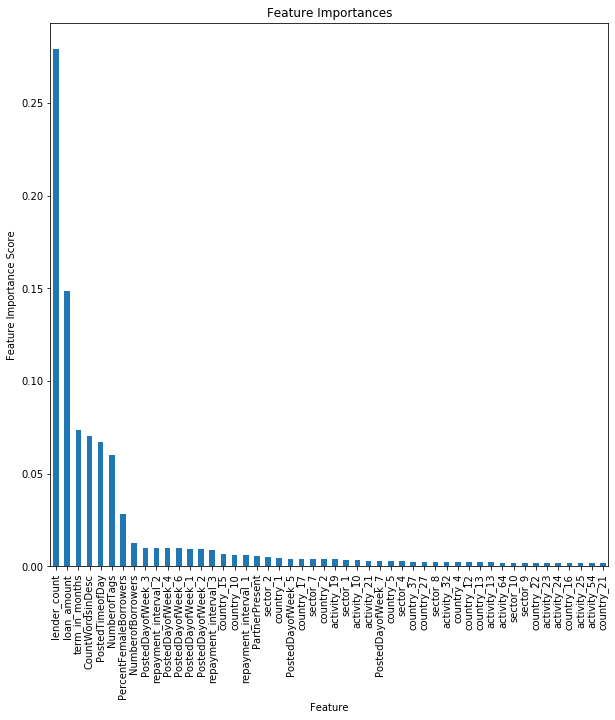

In [24]:
plt.figure(figsize=(10, 10))
feat_imp1[:50].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature')

The following features are the most important to this Random Forest:
1. lender_count
2. loan_amount
3. term_in_months
4. CountWordsDesc
5. PostedTimeofDay

Since we tried a bagging model with a Random Forest, let's see if we get any additional improvments with a boosting model in the xgboost library

In [6]:
import xgboost as xgb

xgb1 = xgb.XGBClassifier(n_jobs=-1)

In [11]:
boost_pipe = Pipeline([('ohe', ohe), ('xgbc', xgb1)])

In [12]:
boost_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight

In [ ]:
predicts1 = boost_pipe.predict(X_test)

Text(0.5, 0, 'Feature')

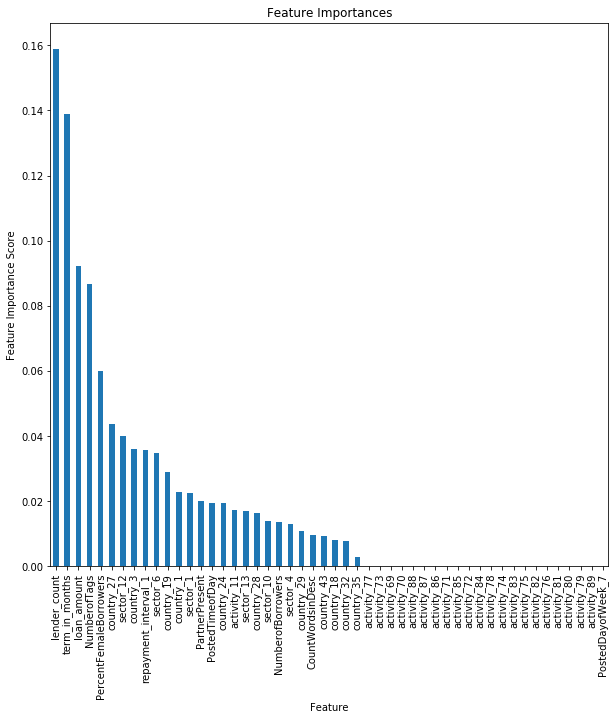

In [20]:
plt.figure(figsize=(10, 10))
feat_imp1[:50].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature')

Pretty weak results! But let's see what happens if we up the number of estimators

In [17]:
r2_score(y_test, predicts1)

0.39192012897982187

In [21]:
xgb2 = xgb.XGBClassifier(n_estimators=500, n_jobs=-1)

boost_pipe2= Pipeline([('ohe', ohe), ('xgbc', xgb2)])

In [22]:
boost_pipe2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=500, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight

Better results than the RandomForestClassifier we used before

In [27]:
boost_pipe2.score(X_test, y_test)

0.9644818784080412

In [23]:
predicts2 = boost_pipe2.predict(X_test)

importing a utils module that we created to help with some plotting

In [ ]:
import utils

plot the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

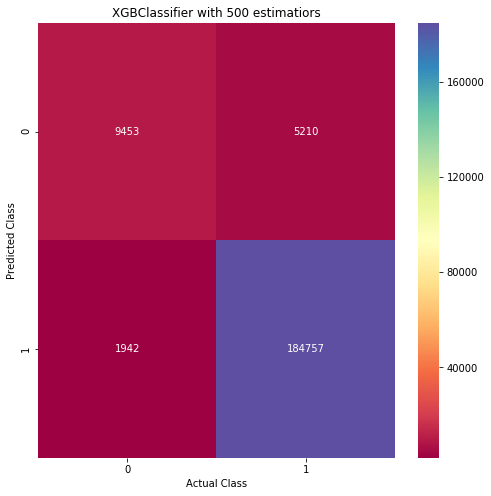

In [36]:
utils.plot_confusion_matrix(y_test, predicts2, cmap='Spectral', title='XGBClassifier with 500 estimatiors')

This model performed quite well for predicting the loan_funded target. We will save the xgboost model because the RandomForestClassifier took up over 500MB of memory

In [13]:
import pickle
with open('xgbc_pipe2.pickle', 'wb') as f:
    pickle.dump(boost_pipe2, f)

## 3. Training TimetoFund Model
#### In this section we are attempting to build a regression model that predcits the time in minutes that it will take to fully fund the loan.
- To preprocess our data our method was to:
    - Use a [One Hot Encoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html) to transform categorical features such as sector, country and activity into columns that describe the presence of the underlying labels within the categories.
    - Scale the data by using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) which transforms the data like so:
$$X_{scaled} = \frac{X - \overline{X}}{\sigma} $$
- In order to create and tune our models, we used a variety of methods, including:
    - Cross Validation:
        - [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
        - [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - Models:
        - [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
        - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
        - [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
        - [XGBoostRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)

In [ ]:
X = pd.read_csv('../X_matrix2.csv')

In [ ]:
y = pd.read_csv('../y_matrix2.csv')

Creating a funded index because we can only train our models on loans that were fully funded

In [ ]:
funded_index = y[y['loan_funded'] == 1].index

In [ ]:
X = X.iloc[funded_index]

In [ ]:
y = y.iloc[funded_index]['TimetoFundMinutes']

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2020)

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

In [129]:
ridge, lasso = Ridge(), Lasso()
sc = StandardScaler()

In [130]:
ridge_pipe = make_pipeline(ohe, sc, ridge)
lasso_pipe = make_pipeline(ohe, sc, lasso)

In [37]:
cv_scores = []

alphas = np.logspace(-3,3,7)

for alpha in alphas:
    ridge.set_params(alpha=alpha)
    # For the value you in the list, set alpha equal to that number
    scores = cross_val_score(estimator=ridge_pipe, X=X_train, y=y_train, cv=10)
    cv_scores.append((np.mean(scores), alpha))

cv_scores

[(0.29208537578161997, 0.001),
 (0.29208607883440757, 0.01),
 (0.2920923189372991, 0.1),
 (0.29212049150476405, 1.0),
 (0.29215213381280264, 10.0),
 (0.29136008437172134, 100.0),
 (0.28306621973369417, 1000.0)]

In [43]:
lasso_pipe.fit(X_train, y_train)

/Users/aoifeduna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1213585228813.5469, tolerance: 21272950880.473713
  positive)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [45]:
pipe.score(X_test, y_test)

0.2928199660168297

Let's make RandomForestRegression pipeline

In [129]:
rf = RandomForestRegressor()

In [130]:
rf_pipe = make_pipeline(ohe, rf)

In [ ]:
rf_pipe.fit(X_train, y_train)

In [205]:
leaf_samples = [1, 5, 10, 15, 20]
rf_scores = []

for sample in leaf_samples:
    # Not saying for alpha in alphas, but same concept
    rf_pipe.steps[-1][1].set_params(min_samples_leaf=sample)
    scores = cross_val_score(estimator=rf_pipe, X=X_train, y=y_train, cv=10)
    rf_scores.append((np.mean(scores), sample))

In [210]:
rf_scores

[(0.48050303815550216, 1),
 (0.5177407571553895, 5),
 (0.5166642901683819, 10),
 (0.5162360897110821, 15),
 (0.513926105060135, 20)]

In [ ]:
rf2 = RandomForestRegressor(n_estimators=20, min_samples_leaf=5,random_state=2020, n_jobs=-1)
rf_pipe2 = make_pipeline(ore, ohe, rf)

In [221]:
rf_pipe2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=20, 

The RandomForestRegressor gives us by far our best results

In [222]:
rf_pipe2.score(Xtime_test, ytime_test)

0.5118221664221869

Going to try out an XGBRegressor

In [ ]:
xgb1 = XGBRegressor(objective='reg:squarederror', n_jobs=2)
ohe = OneHotEncoder(use_cat_names=True)

In [11]:
pipe1 = Pipeline([('ohe', ohe), ('xgb', xgb1)])

In [13]:
pipe1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=2,
                              nthread=None, objective='reg:squarederror',
                              random_state=0, reg_alpha=0, reg_lambda=1,
  

In [14]:
pipe1.score(X_test, y_test)

0.43517708612598005

In [15]:
preds1 = pipe1.predict(X_test)

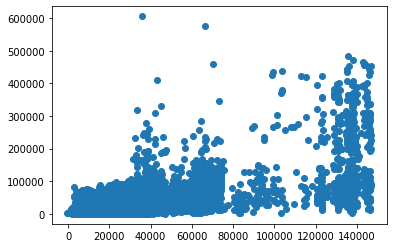

In [17]:
plt.scatter(preds1, y_test)

Using GridSearchCV to tune the parameters. First we are going to tune the max_depth of the trees

In [18]:
params1 = {
    'xgb__max_depth': [3, 5, 7]
} 

In [20]:
gsearch1 = GridSearchCV(pipe1, params1, scoring='r2', n_jobs=2, cv=3, verbose=4)
gsearch1.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 14.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(cols=['activity',
                                                            'sector', 'country',
                                                            'repayment_interval',
                                                            'PostedDayofWeek'],
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                                                      use_cat_names=True,
                                                      verbose=0)),
                                       ('xgb',
                                        XGBRegressor(base_score=0.5

In [21]:
gsearch1.score(X_test, y_test)

0.505991701741332

In [22]:
gsearch1.best_params_, gsearch1.best_score_

({'xgb__max_depth': 7}, 0.5044714273915619)

In [12]:
pipe1.steps[-1][1].set_params(max_depth=7)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=2, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [24]:
pipe1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=2,
                              nthread=None, objective='reg:squarederror',
                              random_state=0, reg_alpha=0, reg_lambda=1,
  

In [27]:
pipe1.score(X_test, y_test)

0.505991701741332

Going to add more estimators to the model to see if that will improve the score

In [13]:
params2 = {
    'xgb__n_estimators': [300, 500]
} 

In [14]:
gsearch2 = GridSearchCV(pipe1, params2, scoring='r2',n_jobs=3, cv=3, verbose=25)
gsearch2.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed: 11.4min
[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed: 11.4min remaining: 22.7min
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed: 11.4min remaining: 11.4min
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed: 29.5min remaining: 14.8min
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed: 29.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed: 29.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                                                      use_cat_names=True,
                                                      verbose=0)),
                                       ('xgb',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                              

In [15]:
gsearch2.best_params_, gsearch2.best_score_

({'xgb__n_estimators': 500}, 0.5250962186212741)

We see that the model with a max_depth of 7 and 500 estimators has our best score yet, so we will save this one

In [16]:
gsearch2.score(X_test, y_test)

0.5384523272879211

In [17]:
pipe1.set_params(**gsearch2.best_params_)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=None, drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=1,
                              missing=None, n_estimators=500, n_jobs=2,
                              nthread=None, objective='reg:squarederror',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1))],
       

In [18]:
pipe1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=1,
                              missing=None, n_estimators=500, n_jobs=2,
                              nthread=None, objective='reg:squarederror',
                              random_state=0, reg_alpha=0, reg_lambda=1,
  

In [20]:
import pickle
with open('xgbr_timefund2.pickle', 'wb') as f:
    pickle.dump(pipe1, f)

In [21]:
preds_g2 = pipe1.predict(X_test)

Going to clip the predictions as a loan cannot be funded before it is posted!

In [50]:
preds_g2 = np.maximum(0, preds_g2)

In [23]:
from sklearn.metrics import r2_score, mean_squared_log_error

In [51]:
r2_score(y_test, preds_g2)

0.5384734018188746

In [52]:
mean_squared_log_error(y_test, preds_g2)

0.7845940819921131

Using the utils.plot_predictions function to both plot and save the predictions vs actual time funded

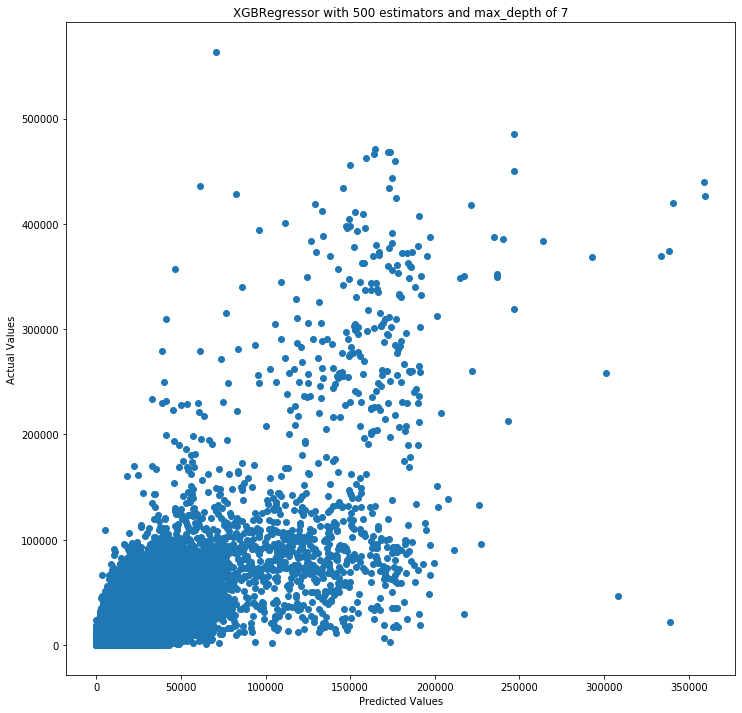

In [48]:
utils.plot_predictions(y_test, preds_g2, title='XGBRegressor with %d estimators and max_depth of 7' % gsearch2.best_params_['xgb__n_estimators'], 
                       figsize=(12,12), save_to='timefunded_predsXgboost1.png')

Going to tune the min_child_weight and subsample parameters to see if our scores improve

In [31]:
params3 = {
    'xgb__min_child_weight': [3, 6],
    'xgb__subsample': [0.6, 0.8]
} 

In [32]:
gsearch3 = GridSearchCV(pipe1, params3, scoring='r2', n_jobs=4, cv=3, verbose=50)
gsearch3.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 19.1min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed: 22.1min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed: 22.1min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed: 22.2min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 38.5min
[Parallel(n_jobs=4)]: Done   6 out of  12 | elapsed: 41.2min remaining: 41.2min
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed: 43.8min remaining: 31.3min
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 44.0min remaining: 22.0min
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed: 60.3min remaining: 20.1min
[Parallel(n_jobs=4)]: Done  10 out of  12 | elapsed: 60.4min remaining: 12.1min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 62.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 62.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(cols=['activity',
                                                            'sector', 'country',
                                                            'repayment_interval',
                                                            'PostedDayofWeek'],
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                                                      use_cat_names=True,
                                                      verbose=0)),
                                       ('xgb',
                                        XGBRegressor(base_score=0.5

In [33]:
gsearch3.best_params_, gsearch3.best_score_

({'xgb__min_child_weight': 3, 'xgb__subsample': 0.8}, 0.5196704230391548)

In [34]:
pipe1.set_params(**gsearch3.best_params_).fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=3,
                              missing=None, n_estimators=500, n_jobs=2,
                              nthread=None, objective='reg:squarederror',
                              random_state=0, reg_alpha=0, reg_lambda=1,
  

In [42]:
preds_g3 = pipe1.predict(X_test)
preds_g3 = np.maximum(0, preds_g3)

This is the best score we have gotten so far, lets save this too

In [43]:
r2_score(y_test, preds_g3)

0.5443485814350504

In [44]:
mean_squared_log_error(y_test, preds_g3)

0.7975728775485428

In [35]:
with open('xgbr_timefund3.pickle', 'wb') as f:
    pickle.dump(pipe1, f)

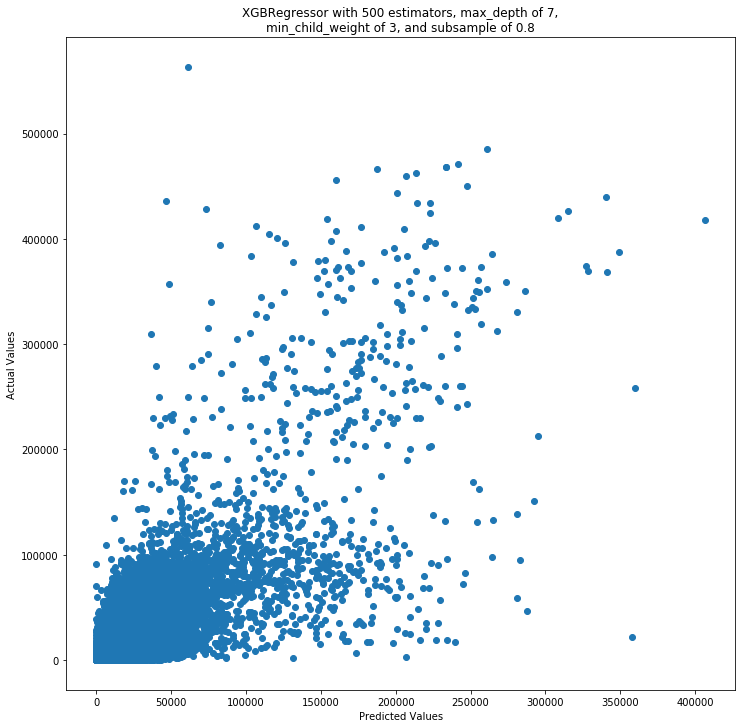

In [49]:
utils.plot_predictions(y_test, preds_g3, title='XGBRegressor with 500 estimators, max_depth of 7,\nmin_child_weight of %d, and subsample of %.1f' % (gsearch3.best_params_['xgb__min_child_weight'], gsearch3.best_params_['xgb__subsample']), 
                       figsize=(12,12), save_to='timefunded_predsXgboost2.png')

In [9]:
feats = pipe1.steps[0][1].get_feature_names()
imps = pipe1.steps[-1][1].feature_importances_
feat_imps = pd.Series(imps, index=feats).sort_values(ascending=False)

PartnerPresent is ~6x more important than the next most important feature when it comes to predicting the time it takes to fund a loan

PartnerPresent                              0.194463
sector_Education                            0.034247
repayment_interval_monthly                  0.029641
sector_Arts                                 0.017776
sector_Manufacturing                        0.017292
country_Lao People's Democratic Republic    0.016423
sector_Health                               0.015837
sector_Retail                               0.012911
NumberofTags                                0.012479
country_El Salvador                         0.012355
dtype: float32


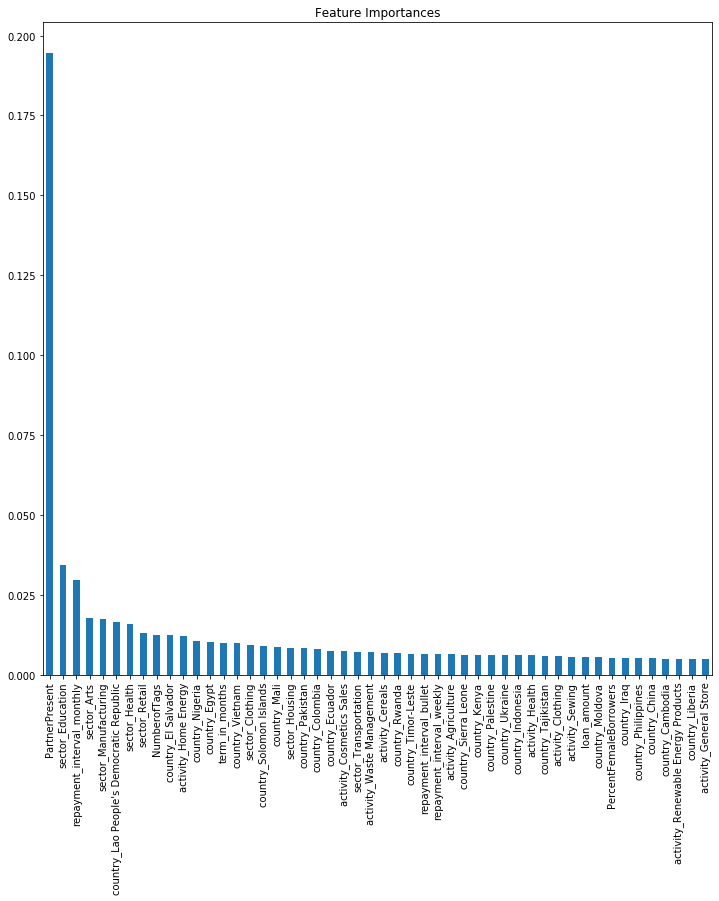

In [12]:
plt.figure(figsize=(12, 12))
print(feat_imps[:10])
feat_imps[:50].plot(kind='bar', title='Feature Importances')

## 4. Training PercentFunded Model
#### In this section we are attempting to build a regression model that predicts what percent of the loan will get funded. We are creating this model because not every loan gets fully funded
- To preprocess our data our method was to:
    - Use a [One Hot Encoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html) to transform categorical features such as sector, country and activity into columns that describe the presence of the underlying labels within the categories.
    - Scale the data by using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) which transforms the data like so:
$$X_{scaled} = \frac{X - \overline{X}}{\sigma} $$
- In order to create and tune our models, we used a variety of methods, including:
    - Cross Validation:
        - [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
        - [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - Models:
        - [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
        - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
        - [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
        - [XGBoostRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)

In [ ]:
from sklearn.linear_model import LinearRegression

In [2]:
X = pd.read_csv('../KivaLoans_data/X_matrix2.csv')

In [3]:
y = pd.read_csv('../KivaLoans_data/y_matrix2.csv')

In [4]:
y = y['PercentFunded']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2020)

In [ ]:
lreg = LinearRegression()

In [59]:
pctscores = cross_val_score(estimator=lreg, X=X_train, y=y_train, cv=10)
scores

array([0.51706429, 0.52011791, 0.51468249, 0.51521576, 0.51303315,
       0.51427782, 0.53540193, 0.51508248, 0.53013899, 0.52032734])

In [61]:
ridge_pipe = make_pipeline(ohe, sc, ridge)

In [62]:
ridge_pipe.fit(Xpct_train, ypct_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=1000.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [63]:
ridge_pipe.score(X_test, y_test)

-1.0897998784742269

In [64]:
lasso_pipe = make_pipeline(ore, ohe, sc, lasso)

In [65]:
lasso_pipe.fit(Xpct_train, ypct_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [67]:
lasso_pipe.score(Xpct_test, ypct_test)

-2.5387752302652444e-06

In [69]:
leaf_samples = [1, 5, 10, 15]
pct_rf_scores = []

for sample in leaf_samples:
    # Not saying for alpha in alphas, but same concept
    rf_pipe.steps[-1][1].set_params(min_samples_leaf = sample)
    scores = cross_val_score(estimator=rf_pipe, X=Xpct_train, y=ypct_train, cv=10)
    rf_scores.append((np.mean(scores), sample))

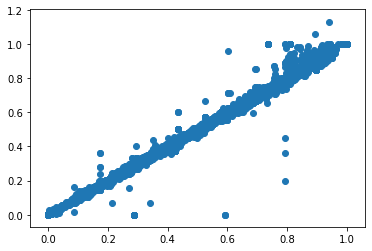

In [71]:
pct_rf_ypred = rf.predict(Xpct_train)
plt.scatter(pct_rf_ypred, ypct_train)

Going to try to train an XBGRegressor and tune it using GridSearchCV

In [ ]:
import xgboost as xgb

In [9]:
ohe = OneHotEncoder()
xgbr1 = xgb.XGBRegressor(n_jobs=2)
xgb_pipe1 = Pipeline([('ohe', ohe), ('xgbr', xgbr1)])

In [11]:
params1 = {
    'xgbr__max_depth': [1, 3, 5],
    'xgbr__n_estimators': [100, 300, 500]
}

In [12]:
gsearch1 = GridSearchCV(xgb_pipe1, params1, scoring='r2', cv=5, n_jobs=3)
gsearch1.fit(X_train, y_train)

[21:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                                                      use_cat_names=False,
                                                      verbose=0)),
                                       ('xgbr',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                            

In [16]:
gsearch1.best_score_, gsearch1.best_params_

(0.6950382356128417, {'xgbr__max_depth': 5, 'xgbr__n_estimators': 500})

In [21]:
xgb_pipe1.steps[-1][1].set_params(max_depth= 5, n_estimators=500)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [23]:
xgb_pipe1.fit(X_train, y_train)

[21:23:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('xgbr',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=None, n_estimators=500, n_jobs=2,
                              nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
      

An R2 of 70% seems pretty good. Lets save this one and keep tuning to see if we can improve

In [24]:
xgb_pipe1.score(X_test, y_test)

0.7003245892543108

In [25]:
with open('xgbr_pctfnd.pickle', 'wb') as f:
    pickle.dump(xgb_pipe1, f)

In [10]:
xgbr2 = xgb.XGBRegressor(max_depth=5, n_estimators=500, n_jobs=2)
xgb_pipe2 = Pipeline([('ohe', ohe), ('xgbr', xgbr2)])

In [ ]:
xgb_pipe2.steps[-1][1].set_params(**gsearch2.best_params_)

In [ ]:
xgb_pipe2.fit(X_train, y_train)

In [ ]:
with open('xgbr_pctfnd2.pickle', 'wb') as f:
    pickle.dump(xgb_pipe2, f)

Using a custom built function to try and run xgb.cv to find if xgb will hit an early stopping round so we can use less estimators

[07:03:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:24:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training rmse: 0.08458
Test rmse: 0.08808


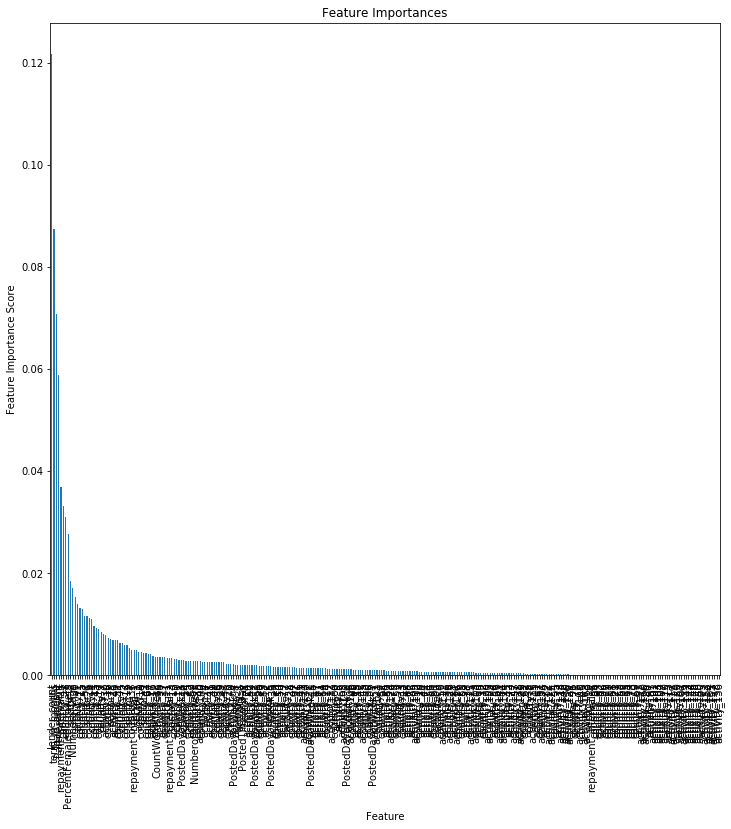

In [18]:
from utils import fit_xgbmodel
fit_xgbmodel(xgb_pipe2.steps[-1][1], X_train, y_train, X_test, y_test, scoring='rmse')

Not better than the first model, so we will use the first

In [32]:
xgb_pipe2[-1].score(X_test.values, y_test.values)

0.6935487540099278

In [65]:
preds1 = xgb_pipe1.predict(X_test)

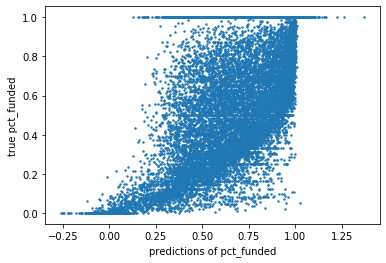

In [71]:
plt.scatter(preds1, y_test, s=2)
plt.xlabel('predictions of pct_funded')
plt.ylabel('true pct_funded')
plt.savefig('pct_funded preds_true.png')

In [72]:
feat_pipe1 = pd.Series(xgb_pipe1.steps[-1][1].feature_importances_, index=xgb_pipe1.steps[0][1].get_feature_names()).sort_values(ascending=False)

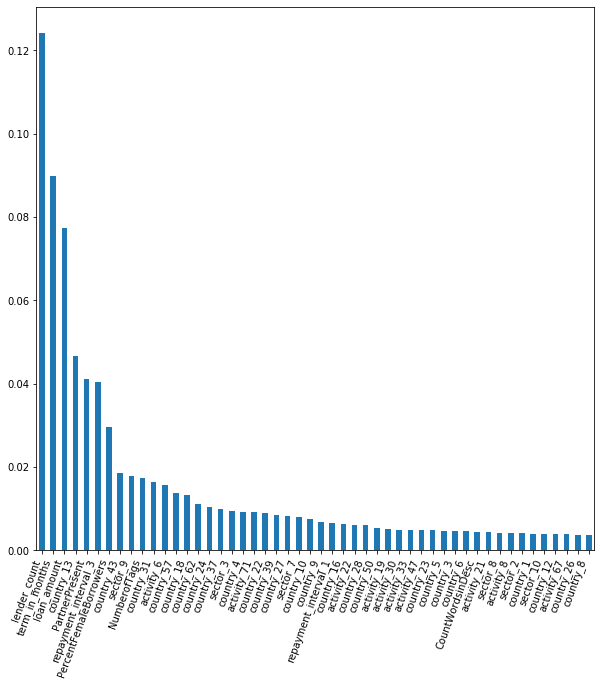

In [93]:
plt.figure(figsize=(10,10))
feat_pipe1[:50].plot(kind='bar')
plt.xticks(rotation=70, ha='right')
plt.savefig('top50feats_pct_fund.png')

## 5. Conclusion

Using different models, we were able to predict the outcomes to our initial questions with a varying level of accuracy.

### Results:
**Whether or not the loan was fully funded:**
- R2 of .96 using XGBoostClassifier

Most important features for this model:
1. lender_count 
2. term_in_months
3. loan_amount
4. sector_Eductation
4. NumberofTags

**If the loan was fully funded, how quickly it was funded:**
- R2 of .54 using XGBoostRegression

Most important features for this model:
1. PartnerPresent
2. sector_Education
3. repayment_interval_monthly
4. sector_Arts
5. sector_Manufacturing

**If the loan was fully funded, what percentage of the loan was funded:**
- R2 of .70 using XGBoostRegression

Most important features for this model:
1. lender_count
2. term_in_months
3. loan_amount
4. country_Iraq
5. PartnerPresent


Kiva's mission is to create financial opportunity for the underserved globally. Ultimately, this data can be used to inform Kiva.org and the loan-seekers on how to increase chances of 1) receiving any funding, 2) being fully funded 3. be fully funded quickly. 
Using this data, we're able to make recommendations to loan seekers to optimize certain factors (amount of the loan request, the length of the loan, what time of day to post, how many words to include in their description, and how many individuals are requesting the loan) to increase their likelihood of securing funding. Similarly, Kiva can use this information to help advise their loan-seekers on how to improve their funding opportunities.